### **CS6501 - MACHINE LEARNING AND APPLICATIONS**
#### **NOTEBOOK-4: Feature Ranking**

**Description:**  
This notebook ranks all features using three models (RF, GB, Lasso) and combines their importances through a voting-based scoring system.
It then merges the scores with the feature metadata (availability, category, usability) to refine and adjust the final rankings.
The output is a final ordered list of high-value features to be used for the final model training.

#### --- Library Imports ---

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler

#### --- Load Cleaned Dataset ---

In [2]:
# path to cleaned BER dataset
cleaned_csv = "../dataset/BERPublicsearch_Cleaned.csv"
# load dataset
df = pd.read_csv(cleaned_csv)
print("Loaded BER dataset with shape:", df.shape)

Loaded BER dataset with shape: (80000, 101)


In [3]:
# select 30K out of the 80K dataset by stratification to run faster
num_bins = 10
df['BER_bin'] = pd.qcut(df['BerRating'], q=num_bins, duplicates='drop')

# Stratified sample of 30k from ~80k
sample_size = 30_000
df, _ = train_test_split(
    df,
    train_size=sample_size,
    stratify=df['BER_bin'],
    random_state=42
)

print("Stratified 30k sample created with shape:", df.shape)

Stratified 30k sample created with shape: (30000, 102)


In [4]:
columns_to_remove = [
    'EnergyRating',   # Categorical BER rating (B1, B2, etc.) derived from BerRating (leakage),
    'BER_bin', # Removing the bin created last cell
    'MPCDERValue' # Later identified as a leakage columns which is calculated from BER rating
]
df = df.drop(columns=[col for col in columns_to_remove if col in df.columns])

#### --- Split Feature and Target ---

In [5]:
target_col = "BerRating" 
X = df.drop(columns=[target_col])
y = df[target_col].copy()

In [6]:
# Identify categorical and numerical columns
num_cols = X.select_dtypes(include=['number']).columns.tolist()
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

#### --- Random Forest Regressor Importance ---

In [7]:
# Preprocessor for numeric and categorical
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ]
)

In [8]:
# Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=0)

In [9]:
# Create a pipeline for preprocessing and model training
rf_feature_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  
    ('random_forest', rf_model)     
])

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
# Fit the pipeline to the full dataset
rf_feature_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['Year_of_Construction',
                                                   'GroundFloorArea(sq m)',
                                                   'UValueWall', 'UValueRoof',
                                                   'UValueFloor',
                                                   'UValueWindow', 'UvalueDoor',
                                                   'WallArea', 'RoofArea',
                                                   'FloorArea', 'WindowArea',
                                                   'DoorArea', 'NoStoreys',
                                                   'HSMainSystemEfficiency',
                                                   'TGDLEdition',
                                                   'HSEffAdjFactor',
                                                   'HSSupplHeatFraction',
                                                   'H...
                                                   'MainWaterHeatingFuel',
                                                   'DraftLobby',
                                                   'VentilationMethod',
                                                   'StructureType',
                                                   'PermeabilityTest',
                                                   'CHBoilerThermostatControlled',
                                                   'ElecImmersionInSummer',
                                                   'InsulationType',
                                                   'PrimaryCircuitLoss',
                                                   'ThermalMassCategory',
                                                   'PredominantRoofType',
                                                   'PurposeOfRating',
                                                   'FirstEnergyType_Description',
                                                   'FirstWallType_Description'])])),
                ('random_forest', RandomForestRegressor(random_state=0))])

In [12]:
# Predict on test data and calculate R^2
y_pred = rf_feature_pipeline.predict(X_test)
rf_r2 = r2_score(y_test, y_pred)
print("Random Forest R^2 on test set:", rf_r2)

Random Forest R^2 on test set: 0.9494472590732058


In [13]:
# Capture feature importances
rf_importances = rf_feature_pipeline.named_steps['random_forest'].feature_importances_
rf_features = list(num_cols) + list(
    rf_feature_pipeline.named_steps['preprocessor']
    .named_transformers_['cat']
    .get_feature_names_out(cat_cols)
)

In [14]:
rf_importance_df = pd.DataFrame({'Feature': rf_features, 'RF_Importance': rf_importances})
rf_importance_df.sort_values(by='RF_Importance', ascending=False, inplace=True)
rf_importance_df.head(10)

,Feature,RF_Importance
2,UValueWall,0.382409
39,DeclaredLossFactor,0.192400
46,DeliveredEnergyPumpsFans,0.062608
31,TempAdjustment,0.061074
3,UValueRoof,0.046948
13,HSMainSystemEfficiency,0.030877
4,UValueFloor,0.030211
1,GroundFloorArea(sq m),0.017468
41,TempFactorMultiplier,0.014885
18,WHMainSystemEff,0.012311


#### --- Gradient Boosting Regressor Importance ---

In [15]:
# --- Gradient Boosting
gb_model = GradientBoostingRegressor(n_estimators=200, learning_rate=0.05, random_state=0)

In [16]:
# Create a pipeline for preprocessing and model training
gb_feature_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('gradient_boosting', gb_model)
])

In [17]:
# Fit the pipeline on training data
gb_feature_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['Year_of_Construction',
                                                   'GroundFloorArea(sq m)',
                                                   'UValueWall', 'UValueRoof',
                                                   'UValueFloor',
                                                   'UValueWindow', 'UvalueDoor',
                                                   'WallArea', 'RoofArea',
                                                   'FloorArea', 'WindowArea',
                                                   'DoorArea', 'NoStoreys',
                                                   'HSMainSystemEfficiency',
                                                   'TGDLEdition',
                                                   'HSEffAdjFactor',
                                                   'HSSupplHeatFraction',
                                                   'H...
                                                   'StructureType',
                                                   'PermeabilityTest',
                                                   'CHBoilerThermostatControlled',
                                                   'ElecImmersionInSummer',
                                                   'InsulationType',
                                                   'PrimaryCircuitLoss',
                                                   'ThermalMassCategory',
                                                   'PredominantRoofType',
                                                   'PurposeOfRating',
                                                   'FirstEnergyType_Description',
                                                   'FirstWallType_Description'])])),
                ('gradient_boosting',
                 GradientBoostingRegressor(learning_rate=0.05, n_estimators=200,
                                           random_state=0))])

In [18]:
# Predict on test data and calculate R^2
y_pred_gb = gb_feature_pipeline.predict(X_test)
gb_r2 = r2_score(y_test, y_pred_gb)
print("Gradient Boosting R^2 on test set:", gb_r2)

Gradient Boosting R^2 on test set: 0.9533089234544865


In [19]:
# Capture feature importances
gb_importances = gb_feature_pipeline.named_steps['gradient_boosting'].feature_importances_
gb_features = list(num_cols) + list(
    gb_feature_pipeline.named_steps['preprocessor']
    .named_transformers_['cat']
    .get_feature_names_out(cat_cols)
)

In [20]:
gb_importance_df = pd.DataFrame({'Feature': gb_features, 'GB_Importance': gb_importances})
gb_importance_df.sort_values(by='GB_Importance', ascending=False, inplace=True)
gb_importance_df.head(10)

,Feature,GB_Importance
2,UValueWall,0.325064
39,DeclaredLossFactor,0.126905
4,UValueFloor,0.077380
3,UValueRoof,0.072842
31,TempAdjustment,0.051580
5,UValueWindow,0.048095
13,HSMainSystemEfficiency,0.042431
41,TempFactorMultiplier,0.039666
46,DeliveredEnergyPumpsFans,0.038907
1,GroundFloorArea(sq m),0.029279


#### --- Lasso CV Importance ---

In [21]:
# LassoCV
lasso_model = LassoCV(cv=5, random_state=0)

In [22]:
# Create a pipeline for preprocessing and model training
lasso_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('lasso', lasso_model)
])

In [23]:
# --- Fit on training data
lasso_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['Year_of_Construction',
                                                   'GroundFloorArea(sq m)',
                                                   'UValueWall', 'UValueRoof',
                                                   'UValueFloor',
                                                   'UValueWindow', 'UvalueDoor',
                                                   'WallArea', 'RoofArea',
                                                   'FloorArea', 'WindowArea',
                                                   'DoorArea', 'NoStoreys',
                                                   'HSMainSystemEfficiency',
                                                   'TGDLEdition',
                                                   'HSEffAdjFactor',
                                                   'HSSupplHeatFraction',
                                                   'H...
                                                   'MainSpaceHeatingFuel',
                                                   'MainWaterHeatingFuel',
                                                   'DraftLobby',
                                                   'VentilationMethod',
                                                   'StructureType',
                                                   'PermeabilityTest',
                                                   'CHBoilerThermostatControlled',
                                                   'ElecImmersionInSummer',
                                                   'InsulationType',
                                                   'PrimaryCircuitLoss',
                                                   'ThermalMassCategory',
                                                   'PredominantRoofType',
                                                   'PurposeOfRating',
                                                   'FirstEnergyType_Description',
                                                   'FirstWallType_Description'])])),
                ('lasso', LassoCV(cv=5, random_state=0))])

In [24]:
# Predict on test set and calculate R^2
y_pred_lasso = lasso_pipeline.predict(X_test)
lasso_r2 = r2_score(y_test, y_pred_lasso)
print("LassoCV R^2 on test set:", lasso_r2)

LassoCV R^2 on test set: 0.8030152580996277


In [25]:
# Capture feature importances (coefficients)
lasso_importances = np.abs(lasso_pipeline.named_steps['lasso'].coef_)
lasso_features = list(num_cols) + list(
    lasso_pipeline.named_steps['preprocessor']
    .named_transformers_['cat']
    .get_feature_names_out(cat_cols)
)

In [26]:
lasso_importance_df = pd.DataFrame({'Feature': lasso_features, 'Lasso_Importance': lasso_importances})
lasso_importance_df.sort_values(by='Lasso_Importance', ascending=False, inplace=True)
lasso_importance_df.head(10)

,Feature,Lasso_Importance
1,GroundFloorArea(sq m),0.720533
37,DistributionLosses,0.143723
13,HSMainSystemEfficiency,0.060884
71,FirstEnerProdDelivered,0.021072
68,PrimaryEnergySupplementaryWater,0.016215
51,PrimaryEnergyMainWater,0.013620
52,PrimaryEnergyMainSpace,0.012142
56,CO2MainSpace,0.007896
48,DeliveredEnergyMainSpace,0.007543
49,PrimaryEnergyLighting,0.006012


#### --- Merging Importance ---

In [27]:
def get_base_feature(feature_name, original_features):
    if feature_name in original_features:
        return feature_name
    elif '_' in feature_name:
        return feature_name.rsplit('_', 1)[0]
    else:
        return feature_name

# Map one-hot features to base features and aggregate importances
def aggregate_importances(df, original_features, importance_col):
    df['BaseFeature'] = df['Feature'].apply(lambda x: get_base_feature(x, original_features))
    agg_df = df.groupby('BaseFeature')[importance_col].mean().reset_index()
    return agg_df

In [28]:
original_features = X.columns.tolist() 

# Aggregate for each model
rf_agg = aggregate_importances(rf_importance_df, original_features, 'RF_Importance')
gb_agg = aggregate_importances(gb_importance_df, original_features, 'GB_Importance')
lasso_agg = aggregate_importances(lasso_importance_df, original_features, 'Lasso_Importance')

In [29]:
# Merge on base feature
feature_importances = rf_agg.merge(gb_agg, on='BaseFeature').merge(lasso_agg, on='BaseFeature')

In [30]:
feature_importances

,BaseFeature,RF_Importance,GB_Importance,Lasso_Importance
0,CHBoilerThermostatControlled,0.000169,0.001023,0.000000
1,CO2Lighting,0.001213,0.000031,0.000000
2,CO2MainSpace,0.006211,0.008521,0.007896
3,CO2MainWater,0.002229,0.000156,0.000000
4,CO2PumpsFans,0.001197,0.000023,0.000000
...,...,...,...,...
93,WaterStorageVolume,0.002520,0.003994,0.000000
94,WindowArea,0.002788,0.000604,0.000000
95,Year_of_Construction,0.005621,0.006328,0.000000
96,prob_smarea_error_0corr,0.000831,0.000000,0.000000


### --- Voting-Based Feature Ranking ---

In this section, we combine the feature importances from the three models (Random Forest, Gradient Boosting, LassoCV) into a single voting-based ranking. Each model’s contribution is weighted by its R² score on the held-out test set, so models with higher predictive performance have more influence. The resulting scores reflect a consensus of feature importance, giving us a robust ranking of the most relevant predictors for the BER target.

In [31]:
print(rf_r2,gb_r2,lasso_r2)

0.9494472590732058 0.9533089234544865 0.8030152580996277


In [32]:
# Normalize each model's importance
scaler = MinMaxScaler()
feature_importances[['RF_Importance_scaled','GB_Importance_scaled','Lasso_Importance_scaled']] = scaler.fit_transform(
    feature_importances[['RF_Importance', 'GB_Importance', 'Lasso_Importance']]
)

In [33]:
# Apply R² weights
feature_importances['RF_Weighted'] = feature_importances['RF_Importance_scaled'] * rf_r2
feature_importances['GB_Weighted'] = feature_importances['GB_Importance_scaled'] * gb_r2
feature_importances['Lasso_Weighted'] = feature_importances['Lasso_Importance_scaled'] * lasso_r2

In [34]:
# Compute final voting-based score (mean of weighted importances)
feature_importances['VotingScore'] = feature_importances[
    ['RF_Weighted', 'GB_Weighted', 'Lasso_Weighted']
].mean(axis=1)

In [35]:
# Sort features by voting score
feature_importances.sort_values(by='VotingScore', ascending=False, inplace=True)

In [36]:
feature_importances

,BaseFeature,RF_Importance,GB_Importance,Lasso_Importance,RF_Importance_scaled,GB_Importance_scaled,Lasso_Importance_scaled,RF_Weighted,GB_Weighted,Lasso_Weighted,VotingScore
85,UValueWall,0.382409,0.325064,0.000000,1.000000,1.000000,0.0,0.949447,0.953309,0.000000,0.634252
35,GroundFloorArea(sq m),0.017468,0.029279,0.720533,0.045672,0.090071,1.0,0.043363,0.085866,0.803015,0.310748
8,DeclaredLossFactor,0.192400,0.126905,0.000000,0.503123,0.390401,0.0,0.477689,0.372173,0.000000,0.283287
84,UValueRoof,0.046948,0.072842,0.000000,0.122763,0.224086,0.0,0.116557,0.213623,0.000000,0.110060
77,TempAdjustment,0.061074,0.051580,0.000000,0.159702,0.158677,0.0,0.151629,0.151268,0.000000,0.100966
...,...,...,...,...,...,...,...,...,...,...,...
7,CountyName,0.000026,0.000000,0.000000,0.000062,0.000000,0.0,0.000059,0.000000,0.000000,0.000020
82,TypeofRating,0.000016,0.000000,0.000000,0.000034,0.000000,0.0,0.000032,0.000000,0.000000,0.000011
20,FanPowerManuDeclaredValue,0.000014,0.000000,0.000000,0.000031,0.000000,0.0,0.000029,0.000000,0.000000,0.000010
73,StructureType,0.000008,0.000000,0.000000,0.000015,0.000000,0.0,0.000014,0.000000,0.000000,0.000005


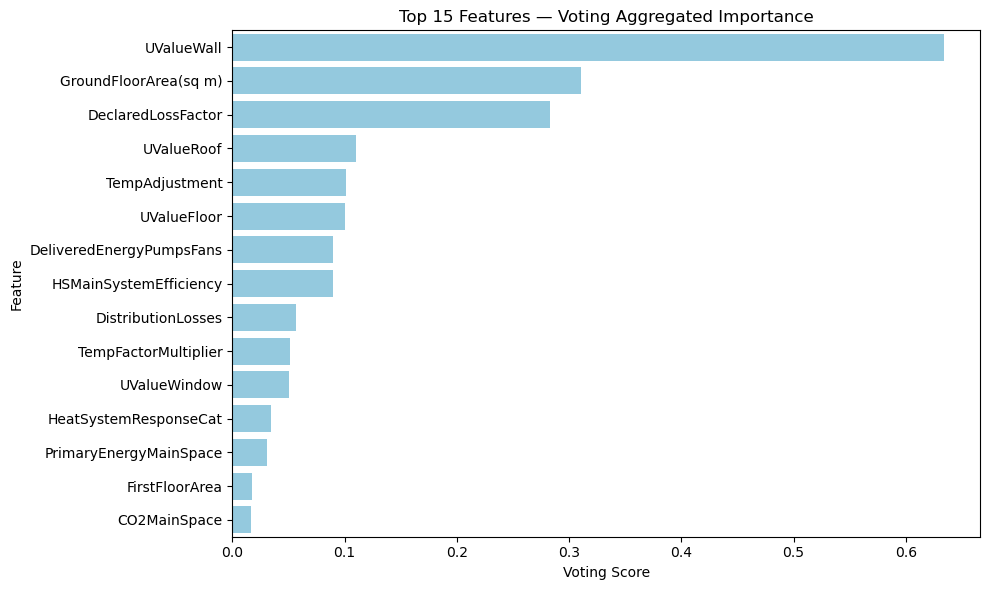

In [37]:
top_features = feature_importances.sort_values('VotingScore', ascending=False).head(15)

# Melt the model-wise importance columns for plotting
top_features_melted = top_features.melt(
    id_vars=['BaseFeature'], 
    value_vars=['RF_Importance', 'GB_Importance', 'Lasso_Importance'], 
    var_name='Model', 
    value_name='Importance'
)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_features,
    x='VotingScore',
    y='BaseFeature',
    color='skyblue'
)
plt.title('Top 15 Features — Voting Aggregated Importance')
plt.xlabel('Voting Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

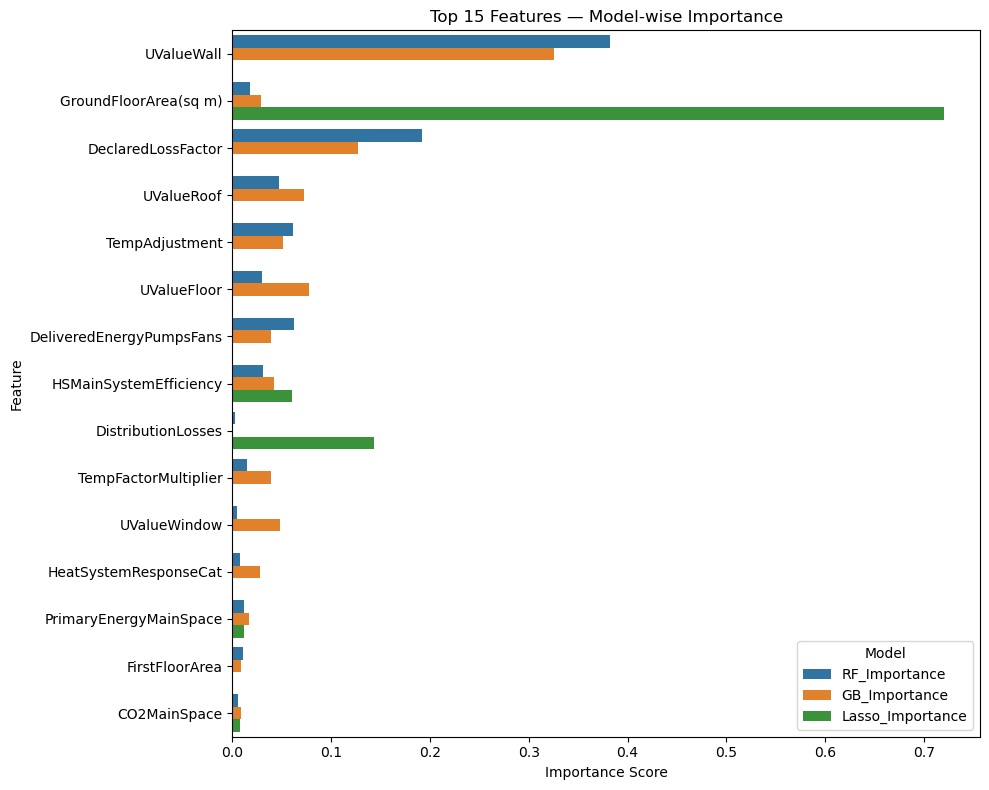

In [38]:
plt.figure(figsize=(10, 8))
sns.barplot(
    data=top_features_melted, 
    x='Importance', 
    y='BaseFeature', 
    hue='Model', 
    orient='h'
)
plt.title('Top 15 Features — Model-wise Importance')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.legend(title='Model')
plt.tight_layout()
plt.show()

#### --- Feature Availability Adjustment ---

Load BER_feature_metadata.csv containing Easy/Medium/Hard scores and merge with the ensemble feature importance. Re-rank features so easily measurable features get more influence while retaining model importance.

In [39]:
# Load metadata with availability scores
metadata_path = "../dataset/BER_feature_metadata.csv"
feature_metadata = pd.read_csv(metadata_path,encoding='latin1')

In [40]:
# Merge with ensemble feature importance
feature_importances = feature_importances.merge(
    feature_metadata[['feature_name', 'category', 'availability']], 
    left_on='BaseFeature',
    right_on='feature_name',
    how='left'
)

In [41]:
# Merge with ensemble feature importance
feature_importances 

,BaseFeature,RF_Importance,GB_Importance,Lasso_Importance,RF_Importance_scaled,GB_Importance_scaled,Lasso_Importance_scaled,RF_Weighted,GB_Weighted,Lasso_Weighted,VotingScore,feature_name,category,availability
0,UValueWall,0.382409,0.325064,0.000000,1.000000,1.000000,0.0,0.949447,0.953309,0.000000,0.634252,UValueWall,Envelope,medium
1,GroundFloorArea(sq m),0.017468,0.029279,0.720533,0.045672,0.090071,1.0,0.043363,0.085866,0.803015,0.310748,GroundFloorArea(sq m),Geometry,easy
2,DeclaredLossFactor,0.192400,0.126905,0.000000,0.503123,0.390401,0.0,0.477689,0.372173,0.000000,0.283287,DeclaredLossFactor,Heating,hard
3,UValueRoof,0.046948,0.072842,0.000000,0.122763,0.224086,0.0,0.116557,0.213623,0.000000,0.110060,UValueRoof,Envelope,medium
4,TempAdjustment,0.061074,0.051580,0.000000,0.159702,0.158677,0.0,0.151629,0.151268,0.000000,0.100966,TempAdjustment,Heating,hard
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,CountyName,0.000026,0.000000,0.000000,0.000062,0.000000,0.0,0.000059,0.000000,0.000000,0.000020,CountyName,Geometry,easy
94,TypeofRating,0.000016,0.000000,0.000000,0.000034,0.000000,0.0,0.000032,0.000000,0.000000,0.000011,TypeofRating,Geometry,easy
95,FanPowerManuDeclaredValue,0.000014,0.000000,0.000000,0.000031,0.000000,0.0,0.000029,0.000000,0.000000,0.000010,FanPowerManuDeclaredValue,Heating,hard
96,StructureType,0.000008,0.000000,0.000000,0.000015,0.000000,0.0,0.000014,0.000000,0.000000,0.000005,StructureType,Geometry,easy


In [42]:
# Map availability to numeric boost factors
availability_weight = {
    "easy": 1.15,      # +15% boost
    "medium": 1.05,    # +5% boost
    "hard": 1.00       # no boost
}

feature_importances['AvailabilityBoost'] = feature_importances['availability'].map(
    availability_weight
)

In [43]:
feature_importances['FinalScore'] = (
    feature_importances['VotingScore'] *
    feature_importances['AvailabilityBoost']
)

In [44]:
feature_importances = feature_importances.sort_values(
    by='FinalScore', ascending=False
).reset_index(drop=True)

In [45]:
feature_importances

,BaseFeature,RF_Importance,GB_Importance,Lasso_Importance,RF_Importance_scaled,GB_Importance_scaled,Lasso_Importance_scaled,RF_Weighted,GB_Weighted,Lasso_Weighted,VotingScore,feature_name,category,availability,AvailabilityBoost,FinalScore
0,UValueWall,0.382409,0.325064,0.000000,1.000000,1.000000,0.0,0.949447,0.953309,0.000000,0.634252,UValueWall,Envelope,medium,1.05,0.665965
1,GroundFloorArea(sq m),0.017468,0.029279,0.720533,0.045672,0.090071,1.0,0.043363,0.085866,0.803015,0.310748,GroundFloorArea(sq m),Geometry,easy,1.15,0.357360
2,DeclaredLossFactor,0.192400,0.126905,0.000000,0.503123,0.390401,0.0,0.477689,0.372173,0.000000,0.283287,DeclaredLossFactor,Heating,hard,1.00,0.283287
3,UValueRoof,0.046948,0.072842,0.000000,0.122763,0.224086,0.0,0.116557,0.213623,0.000000,0.110060,UValueRoof,Envelope,medium,1.05,0.115563
4,UValueFloor,0.030211,0.077380,0.000000,0.078995,0.238046,0.0,0.075002,0.226931,0.000000,0.100644,UValueFloor,Envelope,medium,1.05,0.105677
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,CountyName,0.000026,0.000000,0.000000,0.000062,0.000000,0.0,0.000059,0.000000,0.000000,0.000020,CountyName,Geometry,easy,1.15,0.000022
94,TypeofRating,0.000016,0.000000,0.000000,0.000034,0.000000,0.0,0.000032,0.000000,0.000000,0.000011,TypeofRating,Geometry,easy,1.15,0.000012
95,FanPowerManuDeclaredValue,0.000014,0.000000,0.000000,0.000031,0.000000,0.0,0.000029,0.000000,0.000000,0.000010,FanPowerManuDeclaredValue,Heating,hard,1.00,0.000010
96,StructureType,0.000008,0.000000,0.000000,0.000015,0.000000,0.0,0.000014,0.000000,0.000000,0.000005,StructureType,Geometry,easy,1.15,0.000005


In [46]:
feature_importances = feature_importances.sort_values(
    by='FinalScore', ascending=False
).reset_index(drop=True)

In [47]:
feature_importances.head(50)

,BaseFeature,RF_Importance,GB_Importance,Lasso_Importance,RF_Importance_scaled,GB_Importance_scaled,Lasso_Importance_scaled,RF_Weighted,GB_Weighted,Lasso_Weighted,VotingScore,feature_name,category,availability,AvailabilityBoost,FinalScore
0,UValueWall,0.382409,0.325064,0.000000,1.000000,1.000000,0.000000,0.949447,0.953309,0.000000,0.634252,UValueWall,Envelope,medium,1.05,0.665965
1,GroundFloorArea(sq m),0.017468,0.029279,0.720533,0.045672,0.090071,1.000000,0.043363,0.085866,0.803015,0.310748,GroundFloorArea(sq m),Geometry,easy,1.15,0.357360
2,DeclaredLossFactor,0.192400,0.126905,0.000000,0.503123,0.390401,0.000000,0.477689,0.372173,0.000000,0.283287,DeclaredLossFactor,Heating,hard,1.00,0.283287
3,UValueRoof,0.046948,0.072842,0.000000,0.122763,0.224086,0.000000,0.116557,0.213623,0.000000,0.110060,UValueRoof,Envelope,medium,1.05,0.115563
4,UValueFloor,0.030211,0.077380,0.000000,0.078995,0.238046,0.000000,0.075002,0.226931,0.000000,0.100644,UValueFloor,Envelope,medium,1.05,0.105677
5,TempAdjustment,0.061074,0.051580,0.000000,0.159702,0.158677,0.000000,0.151629,0.151268,0.000000,0.100966,TempAdjustment,Heating,hard,1.00,0.100966
6,DeliveredEnergyPumpsFans,0.062608,0.038907,0.000000,0.163714,0.119690,0.000000,0.155438,0.114101,0.000000,0.089846,DeliveredEnergyPumpsFans,Energy,hard,1.00,0.089846
7,HSMainSystemEfficiency,0.030877,0.042431,0.060884,0.080737,0.130530,0.084499,0.076656,0.124436,0.067854,0.089648,HSMainSystemEfficiency,Heating,hard,1.00,0.089648
8,DistributionLosses,0.003085,0.000671,0.143723,0.008062,0.002064,0.199468,0.007654,0.001968,0.160176,0.056599,DistributionLosses,Heating,hard,1.00,0.056599
9,TempFactorMultiplier,0.014885,0.039666,0.000000,0.038917,0.122025,0.000000,0.036950,0.116327,0.000000,0.051092,TempFactorMultiplier,Geometry,medium,1.05,0.053647


In [49]:
feature_importances.to_csv("../dataset/BER_feature_importance.csv", index=False)